In [1]:
# Initialising required libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime

In [2]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn import metrics



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import DataFrame
import os

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA

In [3]:
data = pd.read_csv('PCDA_UNCLEANED/Car_registration.csv', parse_dates =["DATE"],index_col ="DATE")
data = data.Car_Registration.resample('Q').mean()
type(data)
data = data.to_frame()
data.reset_index(inplace=True)
data.columns = ['DATE','Car_Registration']
data

,DATE,Car_Registration
0,1989-03-31,209744.065200
1,1989-06-30,187700.899100
2,1989-09-30,241806.852210
3,1989-12-31,130589.059673
4,1990-03-31,194182.000000
...,...,...
131,2021-12-31,110189.000000
132,2022-03-31,139186.666667
133,2022-06-30,128173.000000
134,2022-09-30,135429.666667


In [4]:
#Expolaratory Data Analysis

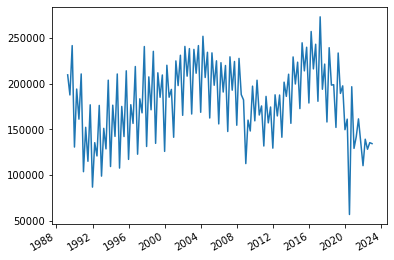

In [5]:
plt.plot(data['DATE'], data['Car_Registration'])
plt.xticks(rotation=30, ha='right')
plt.rcParams['figure.figsize']=(12.8,7.2)

### We can see that there is seasonality within the data but no trend

In [97]:
type(data['Car_Registration'][0])

numpy.float64

### Check to see if the data is stationary 

In [98]:
ad_fuller_result = adfuller(data['Car_Registration'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.328974032121382
p-value: 0.013631978725194734


### The p value is lower than alpha which means that the data is already stationary.

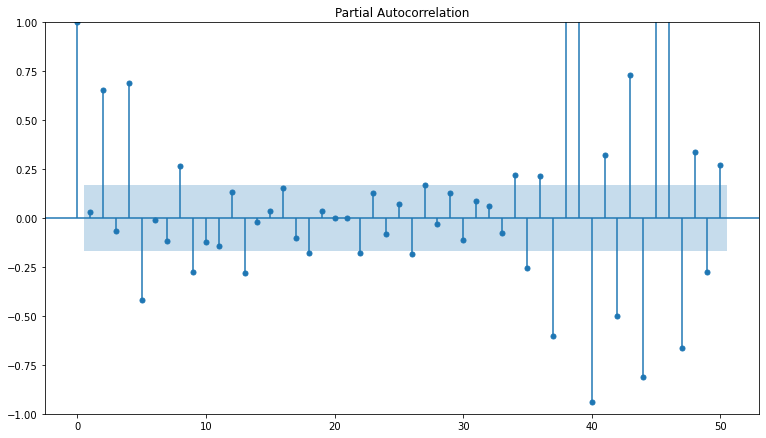

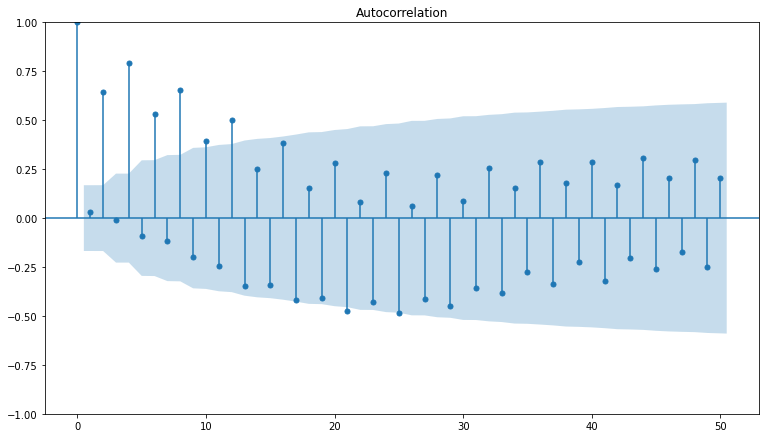

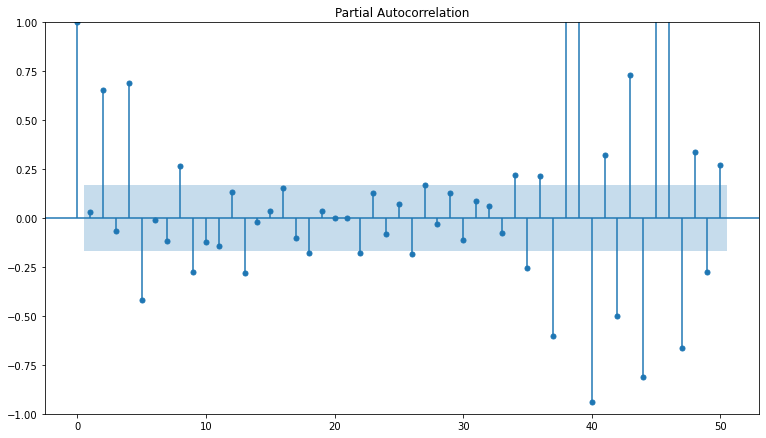

In [99]:
plot_acf(data['Car_Registration'],lags=50)
plot_pacf(data['Car_Registration'],lags=50)


### The arima model can be split up into AR(p), I(d) and MA(q). In the PACF graph, we can see three significant lags within the first 5 lags, making the AR equal to 3. In the ACF graph, we also see three significant lags, making the MA equal to 3. The I or differencing term in the arima model is equal to 0 since we did not need to do any differencing. This makes our model ARIMA(3,0,3). To figure out the PQD part of the ARIMA, see below. 

### We can see that there is still seasonality within the data so we can do seasonal differencing to fix that. 

In [104]:
data['Car_Registration_diff'] = data['Car_Registration'] - data['Car_Registration'].shift(4)

In [105]:
data = data.dropna()
data

,DATE,Car_Registration,Car_Registration_diff
16,1993-03-31,151087.000000,15683.666667
17,1993-06-30,128591.333333,7746.666667
18,1993-09-30,203894.000000,27668.000000
19,1993-12-31,109236.333333,10510.333333
20,1994-03-31,176478.666667,25391.666667
...,...,...,...
131,2021-12-31,110189.000000,-18947.000000
132,2022-03-31,139186.666667,-2655.000000
133,2022-06-30,128173.000000,-33309.666667
134,2022-09-30,135429.666667,-117.333333


In [106]:
ad_fuller_result = adfuller(data['Car_Registration_diff'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.30665521792112
p-value: 0.1698305147345493


### We can see that the p value is lower than alpha which means this differenced data is stationary 

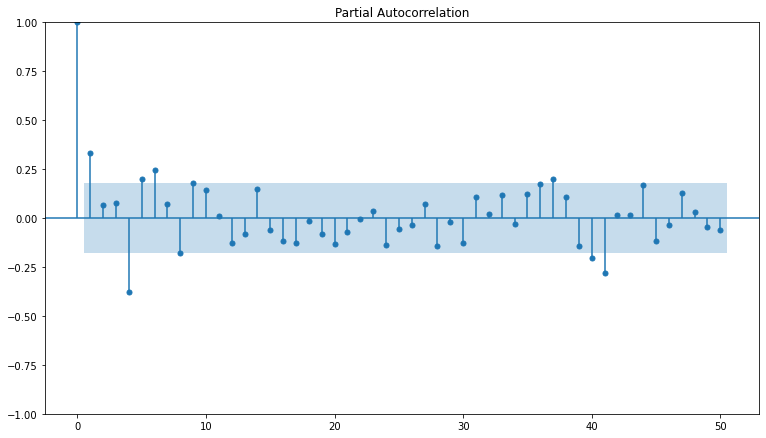

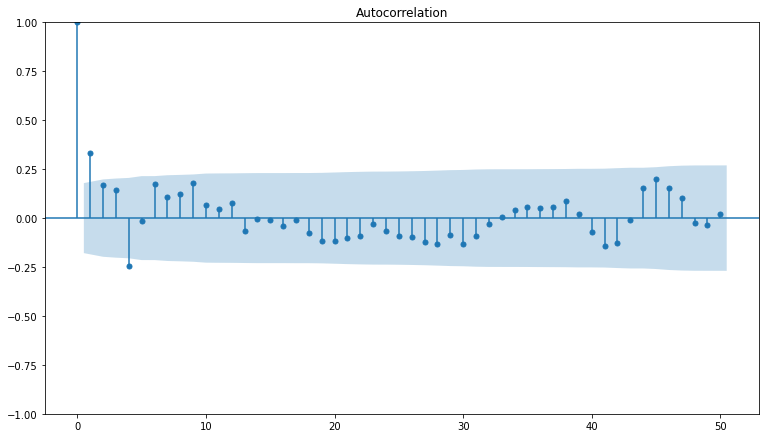

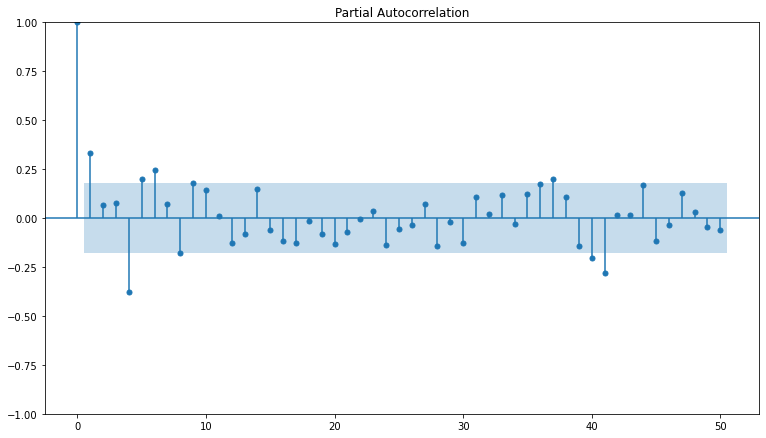

In [107]:
plot_acf(data['Car_Registration_diff'],lags=50)
plot_pacf(data['Car_Registration_diff'],lags=50)

# 

In [82]:
train = data.loc[:106]
test = data.loc[107:]

In [83]:
train

,DATE,Car_Registration,Car_Registration_diff
36,1998-03-31,32399.333333,-7318.666667
37,1998-06-30,29333.666667,8068.666667
38,1998-09-30,21371.666667,-16560.000000
39,1998-12-31,17574.333333,-766.333333
40,1999-03-31,34964.333333,9035.000000
...,...,...,...
102,2014-09-30,49158.333333,56986.333333
103,2014-12-31,43360.000000,26432.333333
104,2015-03-31,57010.666667,29278.000000
105,2015-06-30,49392.333333,32883.333333


In [68]:
model = ARIMA(train['Car_Registration'], order = (3,0,3), seasonal_order=(0,0,0,12))
results = model.fit()

In [69]:
prediction = results.predict(start=106, end=133, dynamic=False)
prediction.columns = ["predicted_values"]
test["predicted_values"] = prediction

In [70]:
test

,DATE,Car_Registration,Car_Registration_diff,predicted_values
107,2015-12-31,37539.000000,55525.666667,14917.368615
108,2016-03-31,55527.333333,57644.000000,14444.422661
109,2016-06-30,30143.666667,9706.666667,14019.090704
110,2016-09-30,32852.666667,-1915.333333,13594.055812
111,2016-12-31,24159.333333,-716.000000,13205.969036
112,2017-03-31,43964.666667,702.666667,12857.443837
113,2017-06-30,-5782.666667,-48396.333333,12519.491332
114,2017-09-30,-2110.333333,-51268.666667,12204.407110
115,2017-12-31,-14677.666667,-58037.666667,11919.171213
116,2018-03-31,-5366.333333,-62377.000000,11648.267255


In [71]:
test = test.dropna()
test

,DATE,Car_Registration,Car_Registration_diff,predicted_values
107,2015-12-31,37539.000000,55525.666667,14917.368615
108,2016-03-31,55527.333333,57644.000000,14444.422661
109,2016-06-30,30143.666667,9706.666667,14019.090704
110,2016-09-30,32852.666667,-1915.333333,13594.055812
111,2016-12-31,24159.333333,-716.000000,13205.969036
112,2017-03-31,43964.666667,702.666667,12857.443837
113,2017-06-30,-5782.666667,-48396.333333,12519.491332
114,2017-09-30,-2110.333333,-51268.666667,12204.407110
115,2017-12-31,-14677.666667,-58037.666667,11919.171213
116,2018-03-31,-5366.333333,-62377.000000,11648.267255


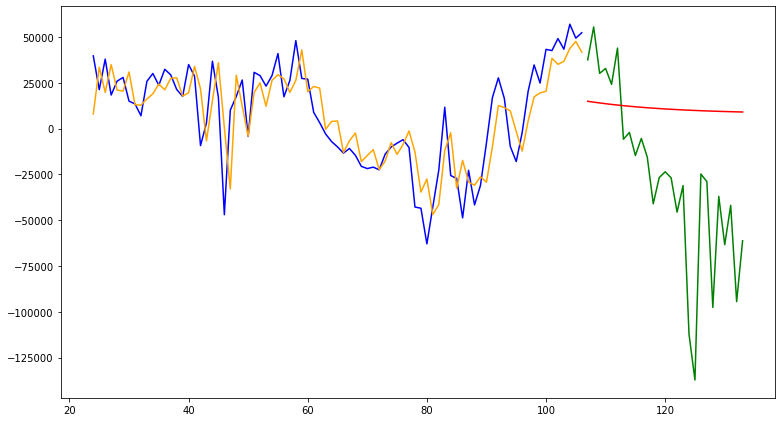

In [72]:
plt.plot(train['Car_Registration'], color = 'Blue', label = "Train")
plt.plot(test['Car_Registration'], color = 'Green', label = "Test")
plt.plot(test['predicted_values'], color ='Red', label = "Prediction")
plt.plot(results.fittedvalues, color='Orange')

In [76]:
MAPE_test=metrics.mean_squared_error(test['Car_Registration'], test['predicted_values'])
MAPE_train=metrics.mean_absolute_percentage_error(train['Car_Registration'], results.fittedvalues)
print("The MAPE for Model Accuracy(test) is",MAPE_test)
print("The MAPE for Model fit(train) is",MAPE_train)

The MAPE for Model Accuracy(test) is 3491579875.306884
The MAPE for Model fit(train) is 0.7731063296657967


### The predicted values are not able to identify the curves in the graph and are graphed as more of a straight line. The MAPE for model fit is low showing that it is able to fit to the train data well. Model accuracy is very high which is not good, meaning that the model is not able to fit the test data well. 